Epoch [1/20] Train Loss: 1.1884, Train Acc: 58.18%, Val Loss: 0.8404, Val Acc: 70.80%
Epoch [2/20] Train Loss: 0.8263, Train Acc: 71.28%, Val Loss: 0.6989, Val Acc: 75.99%
Epoch [3/20] Train Loss: 0.7136, Train Acc: 75.27%, Val Loss: 0.6272, Val Acc: 78.51%
Epoch [4/20] Train Loss: 0.6454, Train Acc: 77.43%, Val Loss: 0.5908, Val Acc: 79.80%
Epoch [5/20] Train Loss: 0.6025, Train Acc: 79.02%, Val Loss: 0.5667, Val Acc: 80.55%
Epoch [6/20] Train Loss: 0.5626, Train Acc: 80.35%, Val Loss: 0.5540, Val Acc: 80.95%
Epoch [7/20] Train Loss: 0.5291, Train Acc: 81.72%, Val Loss: 0.5387, Val Acc: 81.56%
Epoch [8/20] Train Loss: 0.5016, Train Acc: 82.48%, Val Loss: 0.5242, Val Acc: 82.32%
Epoch [9/20] Train Loss: 0.4740, Train Acc: 83.36%, Val Loss: 0.5238, Val Acc: 82.38%
Epoch [10/20] Train Loss: 0.4583, Train Acc: 84.02%, Val Loss: 0.5167, Val Acc: 82.86%
Epoch [11/20] Train Loss: 0.4370, Train Acc: 84.69%, Val Loss: 0.5024, Val Acc: 83.17%
Epoch [12/20] Train Loss: 0.4189, Train Acc: 85.34%,

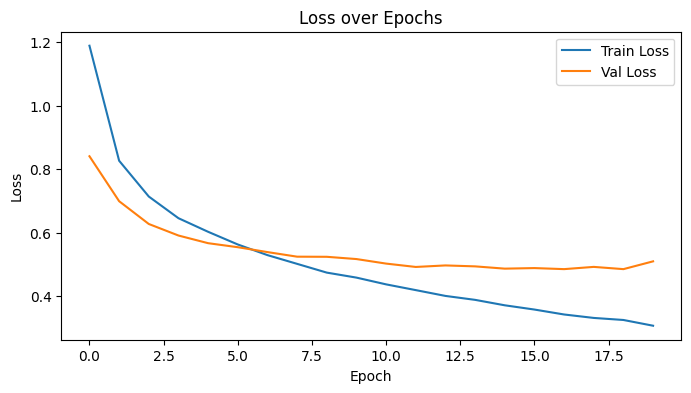

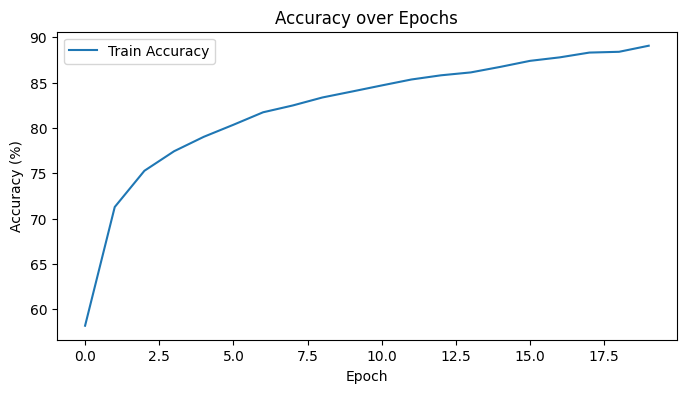

              precision    recall  f1-score   support

    airplane       0.86      0.87      0.86      1000
  automobile       0.91      0.90      0.91      1000
        bird       0.78      0.83      0.80      1000
         cat       0.72      0.67      0.69      1000
        deer       0.80      0.86      0.83      1000
         dog       0.75      0.77      0.76      1000
        frog       0.89      0.88      0.89      1000
       horse       0.92      0.84      0.88      1000
        ship       0.92      0.89      0.90      1000
       truck       0.86      0.90      0.88      1000

    accuracy                           0.84     10000
   macro avg       0.84      0.84      0.84     10000
weighted avg       0.84      0.84      0.84     10000



In [ ]:

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import os

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465),
                         (0.2023, 0.1994, 0.2010))
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465),
                         (0.2023, 0.1994, 0.2010))
])

trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
testset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

batch_size = 64

trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
testloader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)


model = models.resnet18(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, 10)
model = model.to(device)


criterion = nn.CrossEntropyLoss()

optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=5e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=5, factor=0.2)


def train_model(model, criterion, optimizer, scheduler, num_epochs=50):
    train_loss, val_loss, accs = [], [], []

    for epoch in range(num_epochs):
        model.train()
        running_loss, correct, total = 0.0, 0, 0

        for inputs, labels in trainloader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

        train_acc = 100 * correct / total
        train_loss.append(running_loss / len(trainloader))
        accs.append(train_acc)

        model.eval()
        val_running_loss, val_correct, val_total = 0.0, 0, 0
        with torch.no_grad():
            for inputs, labels in testloader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_running_loss += loss.item()

                _, preds = torch.max(outputs, 1)
                val_correct += (preds == labels).sum().item()
                val_total += labels.size(0)

        val_loss.append(val_running_loss / len(testloader))
        val_acc = 100 * val_correct / val_total

        print(f"Epoch [{epoch+1}/{num_epochs}] "
              f"Train Loss: {train_loss[-1]:.4f}, Train Acc: {train_acc:.2f}%, "
              f"Val Loss: {val_loss[-1]:.4f}, Val Acc: {val_acc:.2f}%")

        if isinstance(scheduler, torch.optim.lr_scheduler.ReduceLROnPlateau):
            scheduler.step(val_loss[-1])
        else:
            scheduler.step()

    return train_loss, val_loss, accs


train_loss, val_loss, accs = train_model(model, criterion, optimizer, scheduler, num_epochs=20)


plt.figure(figsize=(8, 4))
plt.plot(train_loss, label='Train Loss')
plt.plot(val_loss, label='Val Loss')
plt.title("Loss over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

plt.figure(figsize=(8, 4))
plt.plot(accs, label='Train Accuracy')
plt.title("Accuracy over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.legend()
plt.show()


def evaluate(model):
    model.eval()
    all_preds, all_labels = [], []

    with torch.no_grad():
        for inputs, labels in testloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    print(classification_report(all_labels, all_preds, target_names=trainset.classes))

evaluate(model)

torch.save(model.state_dict(), "best_cifar10_model.pth")